#  Обнаружение объектов

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
* https://pyimagesearch.com/2021/11/01/training-an-object-detector-from-scratch-in-pytorch/
* https://pyimagesearch.com/2021/08/02/pytorch-object-detection-with-pre-trained-networks/

## Задачи для совместного разбора

1\. Рассмотрите простейшую архитектуру для решения задачи object detection и процесс настройки модели.

In [1]:
import torch as th
import torch.nn as nn

In [2]:
imgs = th.rand(size=(16, 3, 100, 100))
bboxes_true = th.rand(size=(16, 4))
labels_true = th.randint(0, 2, size=(16, ))

In [3]:
class Detector(nn.Module):
  def __init__(self):
    super().__init__()
    self.backbone = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    self.regressor = nn.Sequential(
        nn.Linear(153664, 64),
        nn.ReLU(),
        nn.Linear(64, 4)
    )

    self.classifier = nn.Sequential(
        nn.Linear(153664, 64),
        nn.ReLU(),
        nn.Linear(64, 2)
    )

  def forward(self, X):
    features = self.backbone(X).flatten(start_dim=1)
    bbox = self.regressor(features)
    labels = self.classifier(features)

    return bbox, labels

In [4]:
model = Detector()
bboxes_pred, labels_pred = model(imgs)

In [5]:
mse_criterion = nn.MSELoss()
ce_criterion = nn.CrossEntropyLoss()

In [6]:
loss = (
    0.5*mse_criterion(bboxes_pred, bboxes_true) +
    0.5*ce_criterion(labels_pred, labels_true)
)

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Напишите функцию `parse_xml`, которая читает xml-файл с разметкой изображения из архива `animals.zip` и возвращает словарь, содержащий три ключа:
```
{
        "raw": # словарь с ключами xmin, ymin, xmax, ymax
        "scaled": # словарь с ключами xmin, ymin, xmax, ymax
        "obj_name": # строка
}
```
В этом словаре `row` - абсолютные значения координат вершин bounding box, а `scaled` - относительные (нормированные на ширину и высоту изображения). Примените функцию к файлу `cat.0.xml` и выведите результат на экран.


- [ ] Проверено на семинаре

In [7]:
import os
import zipfile
from pathlib import Path
import xml.etree.ElementTree as ET
from PIL import Image
import torch
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.transforms import ToPILImage, Compose, ToTensor, Normalize, Resize
from torchvision.models import resnet50
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

In [8]:
def parse_xml(xml_filename):
    with zipfile.ZipFile('animals.zip') as z:        
        with z.open(f'Asirra: cat vs dogs/{xml_filename}') as f:
            tree = ET.parse(f)
            root = tree.getroot()
            
            size = root.find("size")
            width = int(size.find("width").text)
            height = int(size.find("height").text)
            
            obj = root.find("object")
            obj_name = obj.find("name").text
            
            bndbox = obj.find("bndbox")
            xmin = float(bndbox.find("xmin").text)
            ymin = float(bndbox.find("ymin").text)
            xmax = float(bndbox.find("xmax").text)
            ymax = float(bndbox.find("ymax").text)
            
            raw = {
                "xmin": xmin,
                "ymin": ymin,
                "xmax": xmax,
                "ymax": ymax
            }
            
            scaled = {
                "xmin": xmin / width,
                "ymin": ymin / height,
                "xmax": xmax / width,
                "ymax": ymax / height
            }
            
            return {
                "raw": raw,
                "scaled": scaled,
                "obj_name": obj_name
            }

parse_xml('cat.0.xml')

{'raw': {'xmin': 126.0, 'ymin': 83.0, 'xmax': 354.0, 'ymax': 243.0},
 'scaled': {'xmin': 0.252,
  'ymin': 0.22192513368983957,
  'xmax': 0.708,
  'ymax': 0.6497326203208557},
 'obj_name': 'cat'}

<p class="task" id="2"></p>

2\. Опишите датасет `AnimalDetectionDataset` на основе архива `animals.zip`. Реализуйте `__getitem__` таким образом, чтобы он возвращал три элемента: тензор с изображением, словарь с координатами bounding box и метку объекта. Предусмотрите возможность передавать извне при создании датасета набор преобразований для изображений, преобразование для метки объекта (для кодирования) и флаг, показывающий, нужно ли возвращать исходные или нормированные координаты bounding box.

- [ ] Проверено на семинаре

In [9]:
class AnimalDetectionDataset(Dataset):
    def __init__(self, 
                 zip_path, 
                 transforms=None, 
                 target_transform=None, 
                 return_scaled_coords=True):

        self.zip_path = zip_path
        self.transforms = transforms
        self.target_transform = target_transform
        self.return_scaled_coords = return_scaled_coords

        with zipfile.ZipFile(self.zip_path) as z:
            self.file_list = z.namelist()
        
        self.image_files = [f for f in self.file_list if f.endswith('.jpg')]
        self.annotation_files = [f.replace('.jpg', '.xml') for f in self.image_files]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        with zipfile.ZipFile(self.zip_path) as z:
            image_path = self.image_files[idx]
            annotation_path = self.annotation_files[idx]

            with z.open(image_path) as img_file:
                image = Image.open(img_file).convert("RGB")

            with z.open(annotation_path) as xml_file:
                tree = ET.parse(xml_file)
                root = tree.getroot()

                size = root.find("size")
                width = int(size.find("width").text)
                height = int(size.find("height").text)

                obj = root.find("object")
                label = obj.find("name").text
                bndbox = obj.find("bndbox")
                xmin = float(bndbox.find("xmin").text)
                ymin = float(bndbox.find("ymin").text)
                xmax = float(bndbox.find("xmax").text)
                ymax = float(bndbox.find("ymax").text)

                raw_box = {
                    "xmin": xmin,
                    "ymin": ymin,
                    "xmax": xmax,
                    "ymax": ymax
                }
                scaled_box = {
                    "xmin": xmin / width,
                    "ymin": ymin / height,
                    "xmax": xmax / width,
                    "ymax": ymax / height
                }
                bounding_box = scaled_box if self.return_scaled_coords else raw_box

                if self.target_transform:
                    label = self.target_transform(label)

            if self.transforms:
                image = self.transforms(image)

            if not isinstance(image, torch.Tensor):
                image = torch.from_numpy(np.array(image)).permute(2, 0, 1) / 255.0

            return image, bounding_box, label

<p class="task" id="3"></p>

3\. Создайте объект класса `AnimalDetectionDataset` без применения преобразований и со значением `return_scaled=False`. Напишите функцию `show_image_with_bounding_box` для визуализации изображения с добавлением на него bounding box и подписи объекта. Продемонстрируйте работу функцию на изображении собаки и кошки.

- [ ] Проверено на семинаре

In [10]:
def show_image_with_bounding_box(image, bounding_box, label):
    if isinstance(image, torch.Tensor):
        image = ToPILImage()(image)
    
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    xmin, ymin, xmax, ymax = bounding_box['xmin'], bounding_box['ymin'], bounding_box['xmax'], bounding_box['ymax']
    width, height = xmax - xmin, ymax - ymin
    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

    ax.text(xmin, ymin - 10, label, color='red', fontsize=12, weight='bold', backgroundcolor='white')

    plt.axis('off')
    plt.show()

Label: cat, Bounding Box: {'xmin': 126.0, 'ymin': 83.0, 'xmax': 354.0, 'ymax': 243.0}


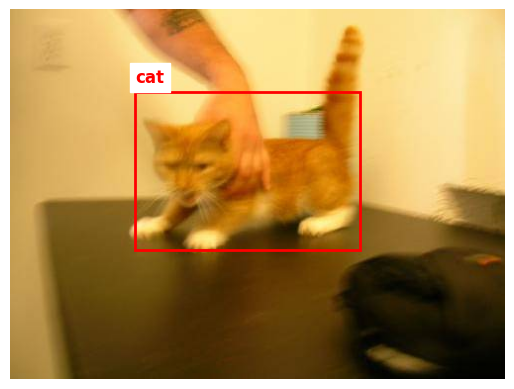

Label: dog, Bounding Box: {'xmin': 58.0, 'ymin': 16.0, 'xmax': 469.0, 'ymax': 373.0}


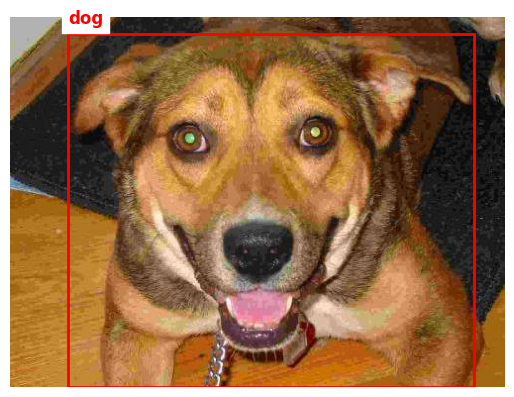

In [11]:
dataset = AnimalDetectionDataset(
    zip_path='animals.zip',
    transforms=None,  
    target_transform=None, 
    return_scaled_coords=False 
)

image, bounding_box, label = dataset[0]
print(f"Label: {label}, Bounding Box: {bounding_box}")
show_image_with_bounding_box(image, bounding_box, label)

image, bounding_box, label = dataset[-1]
print(f"Label: {label}, Bounding Box: {bounding_box}")
show_image_with_bounding_box(image, bounding_box, label)

<p class="task" id="4"></p>

4\. Напишите модель для решения задачи выделения объектов. Реализуйте двухголовую сеть, одна голова которой предсказывает метку объекта (задача классификации), а вторая голова предсказывает 4 координаты вершин bounding box (задача регрессии). В качестве backbone используйте модель resnet50 из пакета `torchvision`.

- [ ] Проверено на семинаре

In [12]:
class Detector(nn.Module):
  def __init__(self):
    super().__init__()
    backbone = resnet50(pretrained=True)
    self.backbone = nn.Sequential(*list(backbone.children())[:-2])

    self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
    
    self.regressor = nn.Sequential(
        nn.Flatten(),
        nn.Linear(2048, 512),
        nn.ReLU(),
        nn.Linear(512, 4)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(2048, 512),
        nn.ReLU(),
        nn.Linear(512, 2)
    )

  def forward(self, X):
    features = self.backbone(X)

    pooled_features = self.global_pool(features)

    bbox = self.regressor(pooled_features)
    labels = self.classifier(pooled_features)

    return bbox, labels

<p class="task" id="5"></p>

5\. Разбейте набор данных на обучающее и валидационное множество. Обучите модель, описанную в задаче 4. При создании датасета не забудьте указать преобразования, соответствующие модели ResNet.

Используйте сумму MSELoss (для расчета ошибки на задаче регрессии) и CrossEntropyLoss (для расчета ошибки на задачи классификации) для настройки весов модели. Для ускорения процесса обучения слои backbone можно заморозить. Во время обучения выводите на экран значения функции потерь на обучающем и валидационном множестве. Используя обученную модель, получите предсказания для изображения кошки и собаки и отрисуйте их. Выполните процедуру, обратную нормализации, чтобы корректно отобразить фотографии.

- [ ] Проверено на семинаре

In [13]:
dataset = AnimalDetectionDataset(
    zip_path="animals.zip",
    transforms=Compose([
        Resize((224, 224)),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    target_transform=lambda label: 0 if label == "cat" else 1,
    return_scaled_coords=True  
)

In [14]:
train_dataset, val_dataset = random_split(dataset, [0.8, 0.2])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

len(train_dataset), len(val_dataset)

(880, 220)

In [15]:
model = Detector()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-5)
criterion_class = nn.CrossEntropyLoss()
criterion_bbox = nn.MSELoss()

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, bboxes, labels in train_loader:
        images = images.to(device)
        bboxes_tensor = torch.stack(
            [bboxes[key].to(torch.float32) for key in ['xmin', 'ymin', 'xmax', 'ymax']], dim=1
        ).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        pred_bboxes, pred_labels = model(images)
        
        loss_class = criterion_class(pred_labels, labels)
        loss_bbox = criterion_bbox(pred_bboxes, bboxes_tensor)
        loss = 0.5 * loss_class +  0.5 * loss_bbox

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, bboxes, labels in val_loader:
            images = images.to(device)
            bboxes_tensor = torch.stack(
                [bboxes[key].to(torch.float32) for key in ['xmin', 'ymin', 'xmax', 'ymax']], dim=1
            ).to(device)
            labels = labels.to(device)

            pred_bboxes, pred_labels = model(images)
            
            loss_class = criterion_class(pred_labels, labels)
            loss_bbox = criterion_bbox(pred_bboxes, bboxes_tensor)
            loss =  0.5 * loss_class +  0.5 * loss_bbox

            val_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss/len(train_loader):.4f} - Val Loss: {val_loss/len(val_loader):.4f}")

c:\Users\Danya\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Danya\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 - Train Loss: 0.3489 - Val Loss: 0.2119
Epoch 2/10 - Train Loss: 0.1628 - Val Loss: 0.1032
Epoch 3/10 - Train Loss: 0.0826 - Val Loss: 0.0581
Epoch 4/10 - Train Loss: 0.0392 - Val Loss: 0.0384
Epoch 5/10 - Train Loss: 0.0224 - Val Loss: 0.0373
Epoch 6/10 - Train Loss: 0.0153 - Val Loss: 0.0247
Epoch 7/10 - Train Loss: 0.0115 - Val Loss: 0.0234
Epoch 8/10 - Train Loss: 0.0102 - Val Loss: 0.0213
Epoch 9/10 - Train Loss: 0.0082 - Val Loss: 0.0193
Epoch 10/10 - Train Loss: 0.0062 - Val Loss: 0.0234


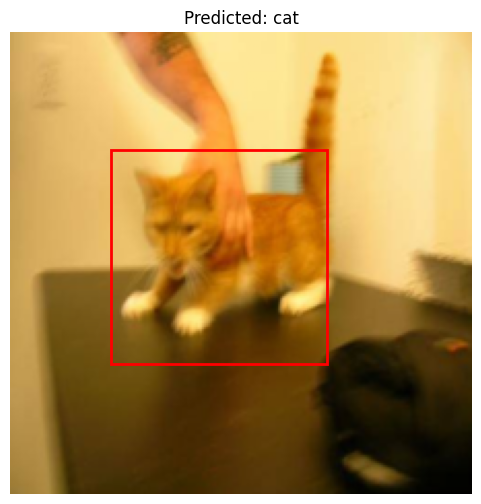

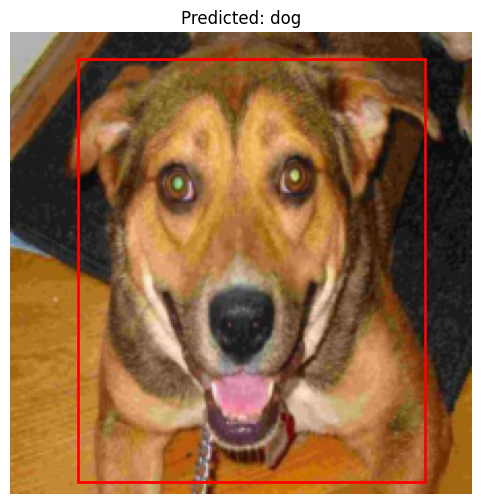

In [16]:
def denormalize(image, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    image = image * std + mean
    return image

def visualize_prediction(image, bbox, label, label_map):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = denormalize(image, mean, std).permute(1, 2, 0).cpu().numpy()
    image = np.clip(image, 0, 1) 

    xmin, ymin, xmax, ymax = bbox
    xmin *= image.shape[1] 
    ymin *= image.shape[0]
    xmax *= image.shape[1]
    ymax *= image.shape[0]

    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.gca().add_patch(plt.Rectangle(
        (xmin, ymin), xmax - xmin, ymax - ymin,
        edgecolor='red', fill=False, linewidth=2
    ))
    plt.title(f"Predicted: {label_map[label]}")
    plt.axis("off")
    plt.show()

label_map = {0: "cat", 1: "dog"}

model.eval()  
with torch.no_grad():
    for i in (0, -1):
        image, bbox, label = dataset[i]
        image_tensor = image.unsqueeze(0).to(device) 
        pred_bboxes, pred_labels = model(image_tensor)

        pred_bbox = pred_bboxes[0].cpu().numpy()  
        pred_label = pred_labels[0].argmax().item() 

        visualize_prediction(image, pred_bbox, pred_label, label_map)

<p class="task" id="6"></p>

6\. Найдите в сети несколько изображений котов и собак. Используя любой инструмент для разметки (например, [CVAT](https://www.cvat.ai/)), выделите котов и собак на изображениях. Вставьте скриншот экспортированного файла с разметкой. Используя полученные изображения, визуализируйте разметку и bounding boxes, полученные при помощи модели.

- [ ] Проверено на семинаре

In [36]:
class AnimalDetectionDataset(Dataset):
    def __init__(self, 
                 zip_path, 
                 transforms=None, 
                 target_transform=None, 
                 return_scaled_coords=True):
        self.zip_path = zip_path
        self.transforms = transforms
        self.target_transform = target_transform
        self.return_scaled_coords = return_scaled_coords

        with zipfile.ZipFile(self.zip_path) as z:
            self.file_list = z.namelist()
        
        self.image_files = [f for f in self.file_list if f.endswith('.jpg')]
        self.annotation_file = [f for f in self.file_list if f.endswith('.xml')][0] 
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        with zipfile.ZipFile(self.zip_path) as z:
            image_path = self.image_files[idx]
            with z.open(image_path) as img_file:
                image = Image.open(img_file).convert("RGB")

            with z.open(self.annotation_file) as xml_file:
                tree = ET.parse(xml_file)
                root = tree.getroot()

                image_name = os.path.basename(image_path)
                image_annotation = root.find(f".//image[@name='{image_name}']")

                if image_annotation is None:
                    raise ValueError(f"No annotation found for image: {image_name}")

                width = int(image_annotation.attrib['width'])
                height = int(image_annotation.attrib['height'])

                box = image_annotation.find("box")
                label = box.attrib['label']
                xmin = float(box.attrib['xtl'])
                ymin = float(box.attrib['ytl'])
                xmax = float(box.attrib['xbr'])
                ymax = float(box.attrib['ybr'])

                raw_box = {
                    "xmin": xmin,
                    "ymin": ymin,
                    "xmax": xmax,
                    "ymax": ymax
                }
                scaled_box = {
                    "xmin": xmin / width,
                    "ymin": ymin / height,
                    "xmax": xmax / width,
                    "ymax": ymax / height
                }
                bounding_box = scaled_box if self.return_scaled_coords else raw_box

                if self.target_transform:
                    label = self.target_transform(label)

            if self.transforms:
                image = self.transforms(image)

            if not isinstance(image, torch.Tensor):
                image = torch.from_numpy(np.array(image)).permute(2, 0, 1) / 255.0

            return image, bounding_box, label

In [37]:
dataset = AnimalDetectionDataset(
    zip_path="Dogs vs Cats.zip",
    transforms=Compose([
        Resize((224, 224)),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    target_transform=lambda label: 0 if label == "Cat" else 1,
    return_scaled_coords=True
)


In [38]:
def visualize_annotation(image, bbox, label, label_map):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = denormalize(image, mean, std).permute(1, 2, 0).cpu().numpy()
    image = np.clip(image, 0, 1)

    xmin, ymin, xmax, ymax = bbox['xmin'], bbox['ymin'], bbox['xmax'], bbox['ymax']
    xmin *= image.shape[1]
    ymin *= image.shape[0]
    xmax *= image.shape[1]
    ymax *= image.shape[0]

    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.gca().add_patch(plt.Rectangle(
        (xmin, ymin), xmax - xmin, ymax - ymin,
        edgecolor='green', fill=False, linewidth=2
    ))
    plt.title(f"Annotation: {label_map[label]}")
    plt.axis("off")
    plt.show()


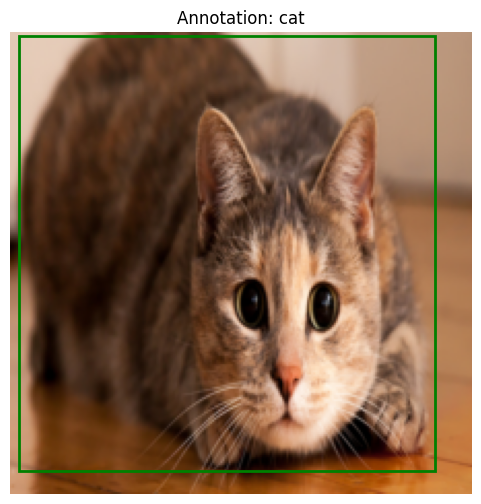

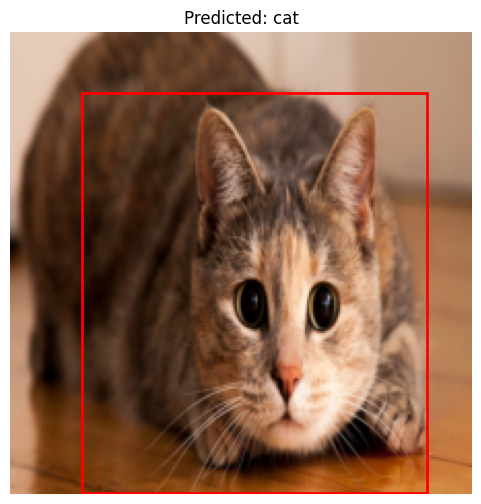

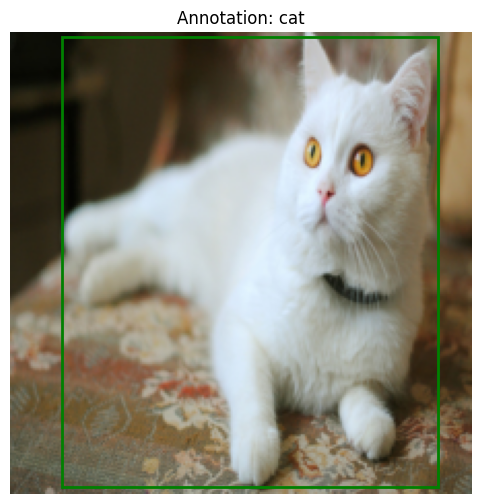

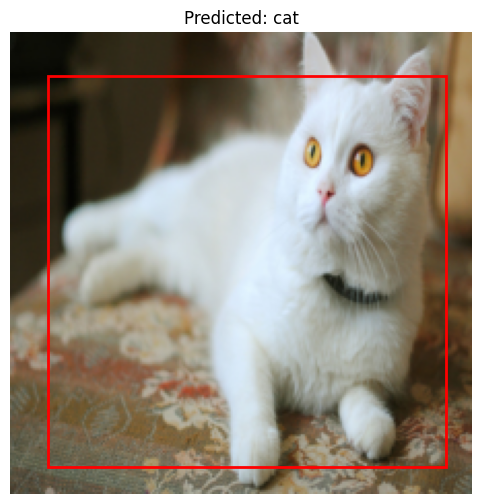

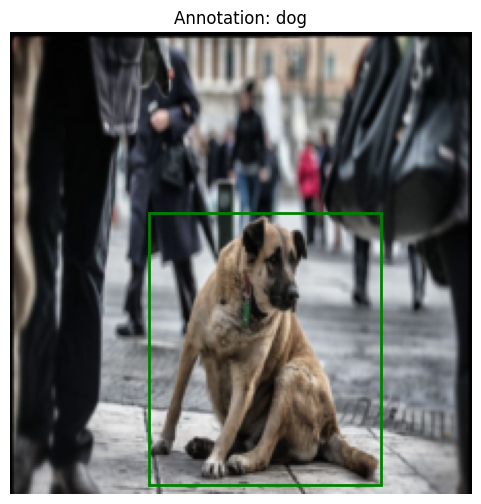

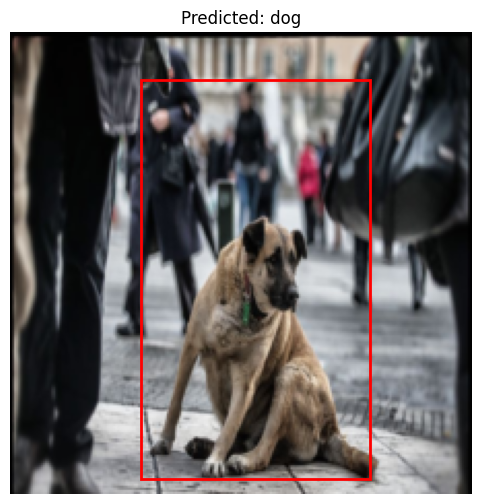

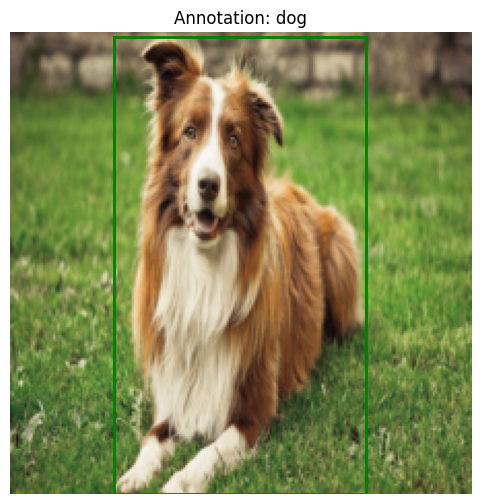

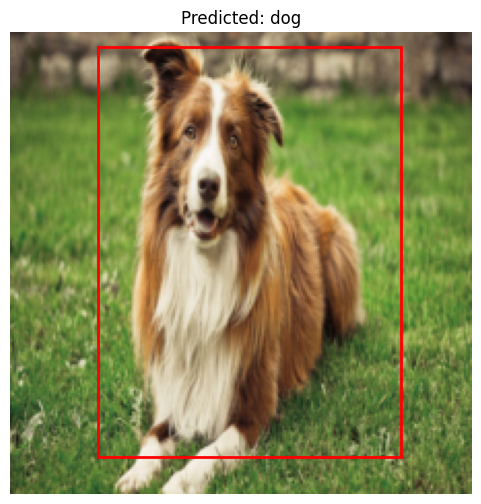

In [39]:
label_map = {0: "cat", 1: "dog"}

model.eval()  
with torch.no_grad():
    for i in range(len(dataset)):
        image, bbox, label = dataset[i]
        image_tensor = image.unsqueeze(0).to(device) 
        
        pred_bboxes, pred_labels = model(image_tensor)
        pred_bbox = pred_bboxes[0].cpu().numpy()  
        pred_label = pred_labels[0].argmax().item() 

        visualize_annotation(image, bbox, label, label_map)
        visualize_prediction(image, pred_bbox, pred_label, label_map)
